In [58]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt; plt.set_cmap('gray')

import torch
import torch.nn as nn
import torch.nn.functional as F

from mesh_detection.dataset import FaceDataset
from mesh_detection.batch_iter import batch_iterator
from mesh_detection.utils import add_channel_dim, randomly_flip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [2]:
kaggle_face_path = Path('../../kaggle_face/training.csv')

In [3]:
ds = FaceDataset(kaggle_face_path)

In [4]:
i = np.random.choice(ds.ids)

In [5]:
img = ds.load_image(i)
kps = ds.load_key_points(i)

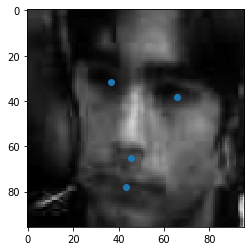

In [6]:
plt.imshow(img)
plt.scatter(*kps.T)

In [56]:
for x, y in batch_iterator(ds.load_image, ds.load_key_points, ds.ids, 50, randomly_flip, add_channel_dim):
    break

In [59]:
t = torch.from_numpy(x)

In [60]:
t.shape

torch.Size([50, 1, 96, 96])

In [66]:
pool = nn.MaxPool2d(2, ceil_mode=True)

In [67]:
pool(pool(pool(pool(pool(pool(t)))))).shape

torch.Size([50, 1, 2, 2])

In [69]:
int(2.7)

2